In [51]:
import h5py
import numpy as np
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import scipy.stats as stats
import seaborn as sns

#conda install -c conda-forge miktex in command prompt
import seaborn as sns
#from ipywidgets import widgets, Layout-this is optionally, must be installed 
#from IPython import display - this is optionally
#from ipywidgets import widgets, Layout


In [52]:
#FOR LATEX -takes longer to run plots

plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']# all text in blots bold
#plt.rc('text', usetex=True)# for figure export 
plt.rc('text', usetex=False)# use tex for image export
PLTSCALFACTOR =1.5# change this to scale all plots labels (3 is good for export on 4k screan)
SMALL_SIZE = 12 * PLTSCALFACTOR
MEDIUM_SIZE = 15 * PLTSCALFACTOR
BIGGER_SIZE = 18 * PLTSCALFACTOR

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['lines.linewidth'] = PLTSCALFACTOR

<ipython-input-52-06400834ace8>:4: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']# all text in blots bold


# 2.Extract the data

Data for ILC comparison is extracted from the HDF5 files separately for PTB and CEM. The extracted data will be sorted by frequency at the end of the Notebook and saved into Excel file.

In [53]:
def extract_data(filename, sensor_index):
    #explore the HDF5 file, folders and subfolders
    with h5py.File(filename,'r') as f:
        base_items=list(f.items())
        print("\nItems in directory", base_items)
        rawtransfer=f.get("RAWTRANSFERFUNCTION")
        rawtransfer_items=list(rawtransfer.items())
        print("\nItems in reference", rawtransfer_items)
        subgroup=rawtransfer.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250")
        subgroup_items=list(subgroup.items())
        print("\n"+sensor_index+"_MPU_9250 items:",subgroup_items)
        subgroup_acceleration=subgroup.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration")
        subgroup_acceleration_items=list(subgroup_acceleration.items())
        print("\nAcceleration items:",subgroup_acceleration_items)
        subgroup_acceleration_5mem=subgroup.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration")
        subgroup_acceleration_5mem_items=list(subgroup_acceleration_5mem.items())
        print("\nAcceleration items_5members:", subgroup_acceleration_5mem_items)
        frequency=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Excitation_frequency")
        frequency_items=list(frequency.items())
        print("\nFrequency", frequency_items)
        magnitude=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Magnitude")
        magnitude_items=list(magnitude.items())
        print("\nMagnitude", magnitude_items)
        phase=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Phase")
        phase_items=list(magnitude.items())
        print("\nPhase", phase_items)
        
        
        #extract frequencies, magnitude, phase, uncertainties and all excitation parameters
        frequency_values=np.array(frequency.get("value"))
        magnitude_values=np.array(magnitude.get("value"))
        magnitude_uncertainties=np.array(magnitude.get("uncertainty"))
        phase_values=np.array(phase.get("value"))
        phase_uncertainties=np.array(phase.get("uncertainty"))
        excitation_freq_items=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Excitation_frequency")
        excitation_freq=np.array(excitation_freq_items.get("value"))
        excitation_amp_items=subgroup_acceleration_5mem.get("/RAWTRANSFERFUNCTION/"+sensor_index+"_MPU_9250/Acceleration/Acceleration/Excitation_amplitude")
        excitation_amp=np.array(excitation_amp_items.get("value"))
        excitation_amp_uncertainty=np.array(excitation_amp_items.get("uncertainty"))
        
        #join all necessary data in 2D array
        total_array=np.stack((frequency_values,magnitude_values,magnitude_uncertainties,phase_values, phase_uncertainties,excitation_freq,excitation_amp,excitation_amp_uncertainty), axis=1)
        print("\nArray dimensions:", total_array.shape)
        column_names=["Frequency in Hz", r"$|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$",r"$U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$", r"$\varphi(\omega)$ in $rad$", r"$U_{\varphi(\omega)}$ in $rad$","Excitation_freq in Hz",r"$A_{excit}$ in $\frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$",r"$U_{Aexcit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"]
        whole_dataset=pd.DataFrame(total_array, columns=column_names)
        f.close()
        
        
        return whole_dataset

In [54]:
whole_dataset_PTB = extract_data('MPU9250PTB_v5.hdf5',"0x1fe40000")


Items in directory [('EXPERIMENTS', <HDF5 group "/EXPERIMENTS" (1 members)>), ('RAWDATA', <HDF5 group "/RAWDATA" (2 members)>), ('RAWTRANSFERFUNCTION', <HDF5 group "/RAWTRANSFERFUNCTION" (1 members)>), ('REFERENCEDATA', <HDF5 group "/REFERENCEDATA" (2 members)>)]

Items in reference [('0x1fe40000_MPU_9250', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250" (1 members)>)]

0x1fe40000_MPU_9250 items: [('Acceleration', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/Acceleration" (1 members)>)]

Acceleration items: [('Acceleration', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/Acceleration/Acceleration" (11 members)>)]

Acceleration items_5members: [('DUT_Phase', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/Acceleration/Acceleration/DUT_Phase" (2 members)>), ('DUT_SNYNC_Phase', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/Acceleration/Acceleration/DUT_SNYNC_Phase" (2 members)>), ('DUT_amplitude', <HDF5 group "/RAWTRANSFERFUNCTION/0x1fe40000_MPU_9250/

In [55]:
whole_dataset_PTB.head(2)

,Frequency in Hz,$|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$,$U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$,$\varphi(\omega)$ in $rad$,$U_{\varphi(\omega)}$ in $rad$,Excitation_freq in Hz,$A_{excit}$ in $\frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$,$U_{Aexcit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$
0,10.0,1.019554,0.003273,-0.094684,0.003022,10.0,2.739,0.004891
1,12.5,1.019093,0.004047,-0.118820,0.006455,12.5,2.744,0.007312


In [56]:
whole_dataset_PTB.head(2)

,Frequency in Hz,$|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$,$U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$,$\varphi(\omega)$ in $rad$,$U_{\varphi(\omega)}$ in $rad$,Excitation_freq in Hz,$A_{excit}$ in $\frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$,$U_{Aexcit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$
0,10.0,1.019554,0.003273,-0.094684,0.003022,10.0,2.739,0.004891
1,12.5,1.019093,0.004047,-0.118820,0.006455,12.5,2.744,0.007312


In [57]:
whole_dataset_CEM = extract_data('MPU9250CEM_v5.hdf5',"0xbccb0000")


Items in directory [('EXPERIMENTS', <HDF5 group "/EXPERIMENTS" (1 members)>), ('RAWDATA', <HDF5 group "/RAWDATA" (2 members)>), ('RAWTRANSFERFUNCTION', <HDF5 group "/RAWTRANSFERFUNCTION" (1 members)>), ('REFERENCEDATA', <HDF5 group "/REFERENCEDATA" (2 members)>)]

Items in reference [('0xbccb0000_MPU_9250', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250" (1 members)>)]

0xbccb0000_MPU_9250 items: [('Acceleration', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/Acceleration" (1 members)>)]

Acceleration items: [('Acceleration', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/Acceleration/Acceleration" (11 members)>)]

Acceleration items_5members: [('DUT_Phase', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/Acceleration/Acceleration/DUT_Phase" (2 members)>), ('DUT_SNYNC_Phase', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/Acceleration/Acceleration/DUT_SNYNC_Phase" (2 members)>), ('DUT_amplitude', <HDF5 group "/RAWTRANSFERFUNCTION/0xbccb0000_MPU_9250/

In [58]:
whole_dataset_CEM[[r"$\varphi(\omega)$ in $rad$"]] = whole_dataset_CEM[[r"$\varphi(\omega)$ in $rad$"]]-np.pi
whole_dataset_CEM.head(2)


,Frequency in Hz,$|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$,$U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$,$\varphi(\omega)$ in $rad$,$U_{\varphi(\omega)}$ in $rad$,Excitation_freq in Hz,$A_{excit}$ in $\frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$,$U_{Aexcit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$
0,80.0,NaN,NaN,NaN,NaN,80.0,NaN,NaN
1,250.0,0.643003,0.000891,-2.375412,0.002897,250.0,126.497513,0.125687


# 3.Data analysis

Cycles in CEM's dataset start with 80.0 Hz and 250.0 Hz instead of 10.0 Hz. These starting points are deleted in order to compare the cycles in a range from 10.0 Hz and 250.Hz.

In [59]:
delete_rows=[]

for k in range(0,171,19):
    i=k
    j=k+1
    delete_rows.append(i)
    delete_rows.append(j)
whole_dataset_CEM_new=whole_dataset_CEM.drop(axis=0,index=delete_rows)

In [60]:
def split_data_by_frequencies(dataset):
    dict_of_frequencies=dict(iter(dataset.groupby("Frequency in Hz")))
    return dict_of_frequencies
    #list_of_frequencies=np.array([10,12.5,16,20,25,31.5,40,46.7,50,53.3,63,80,100,125,160,200,250])

In [61]:
#check if all frequencies are the same
PTB_separated_by_freq=split_data_by_frequencies(whole_dataset_PTB)
CEM_separated_by_freq=split_data_by_frequencies(whole_dataset_CEM)
CEM_separated_by_freq_new=split_data_by_frequencies(whole_dataset_CEM_new)
print("Frequencies - PTB:",PTB_separated_by_freq.keys())
print("Frequencies - CEM:",CEM_separated_by_freq.keys())

Frequencies - PTB: dict_keys([10.0, 12.5, 16.0, 20.0, 25.0, 31.5, 40.0, 46.7, 50.0, 53.3, 63.0, 80.0, 100.0, 125.0, 160.0, 200.0, 250.0])
Frequencies - CEM: dict_keys([10.0, 12.5, 16.0, 20.0, 25.0, 31.5, 40.0, 46.7, 50.0, 53.3, 63.0, 80.0, 100.0, 125.0, 160.0, 200.0, 250.0])


In [62]:
PTB_separated_by_freq.get(10).head(1)

,Frequency in Hz,$|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$,$U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$,$\varphi(\omega)$ in $rad$,$U_{\varphi(\omega)}$ in $rad$,Excitation_freq in Hz,$A_{excit}$ in $\frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$,$U_{Aexcit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$
0,10.0,1.019554,0.003273,-0.094684,0.003022,10.0,2.739,0.004891


In [63]:
CEM_separated_by_freq_new.get(10).head(1)

,Frequency in Hz,$|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$,$U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$,$\varphi(\omega)$ in $rad$,$U_{\varphi(\omega)}$ in $rad$,Excitation_freq in Hz,$A_{excit}$ in $\frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$,$U_{Aexcit}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$
2,10.0,1.016209,0.004893,-0.094907,0.001665,10.0,2.754331,0.00586


In [64]:
q_names=list(PTB_separated_by_freq.get(10).columns)
list_of_freq=[10,12.5,16,20,25,31.5,40,46.7,50,53.3,63,80,100,125,160,200,250]

# 4. En values

The En values for Magnitude, Phase and Excitation amplitude have been calculated according to formula on the figure:
$$\frac{|\bar{x}_{PTB}-\bar{x}_{CEM}|}{\sqrt{{U^{2}}_{PTB}+{U^{2}}_{CEM}}}$$



<br>$x_{PTB}$ corresponds to the mean value at a specific frequency for  PTB
<br>$x_{CEM}$ corresponds to the mean value at a specific frequency for  CEM
<br>$U_{PTB}$ corresponds to the expanded measurement uncertainty of the mean value at a specific frequency for  PTB
<br>$U_{CEM}$ corresponds to the expanded measurement uncertainty of the mean value at a specific frequency CEM
<br>If:<br> |En|<=1.1 - the criteria is satisfied (the original condition is that |En|<=1.0. However, because of the practical reasons, this limit is sometimes enlarged for 10%).
<br>|En|>1.1 - the criteria is not satisfied.
<br>The order of laboratories is not important because it affects only the sign. That is why an absolute values are taken into account. 

## 4.1 The function for En values

In [65]:
def calculate_En_values(df1,df2,names):
    En_values=np.empty((df1.shape[0],2))
    
    for i in range (df1.shape[0]):
        
        En_values[:,0]=np.abs(((df1[names[0]].values-df2[names[0]].values)/(2*(np.sqrt(df1[names[1]].values**2 +df2[names[1]].values**2)))))
        En_values[:,1]=np.abs(((df1[names[2]].values-df2[names[2]].values)/(2*(np.sqrt(df1[names[3]].values**2 +df2[names[3]].values**2)))))
        #En_values[:,2]=np.abs(((df1[names[4]].values-df2[names[4]].values)/(2*(np.sqrt(df1[names[5]].values**2 +df2[names[5]].values**2))))) 
          
    return En_values  

# 5. Case study 3: Calculate En values for Monte Carlo method

## 5.1 Best estimates and standard uncertainties


If it is assumed that each experiment is based on at least 30 single values, then the normal distribution can be proposed:
$$X \hookrightarrow  \mathcal{N}(|S(\omega)|_{i},\,\sigma _{|S(\omega)|_{i}}^{2})$$
where $\sigma _{|S(\omega)|_{i}}$ is calculated as   $\frac{U _{|S(\omega)|_{i}}}{2}$.

The same approach refers to the phase values: 
$$X \hookrightarrow  \mathcal{N}(\varphi(\omega)_{i},\,\sigma _{\varphi(\omega)_{i}}^{2})$$
where $\sigma _{\varphi(\omega)_{i}}$ is calculated as   $\frac{U _{\varphi(\omega)_{,i}}}{2}$. In both cases, *i* refers to the number of experiments at a given frequency (*i*=10 for PTB and *i*=9 for CEM).

The Monte Carlo approach refers tocollection of samples from the probability distributions, which are defined as normal and by statistics (the mean and standard deviation) for every experiment.  Samples from different experiments are then used to calculate the estimate of the output quantity and the associated standard uncertainty at given frequencies within the calibration range. These estimates arethen used to calculate the En values.

In [66]:
def MC(dictionary, names):
    keys =list(dictionary.keys())
    sample_size=30
    dict_val=list(dictionary.values())

    MC_RESULTS=np.empty((len(dictionary.values()),4))
    p=0.05
    q=p*sample_size
    r= (sample_size-q)/2
    q = p*sample_size
    x_low=np.empty(len(dictionary.values()))
    x_high=np.empty(len(dictionary.values()))

    y_low=np.empty(len(dictionary.values()))
    y_high=np.empty(len(dictionary.values()))

    for val, val_in_list in zip(dictionary.values(), range(len(dict_val))):
            X_var=np.empty((len(dictionary.values()),val.shape[0],sample_size))
            Y_var=np.empty((len(dictionary.values()),val.shape[0],sample_size))
    
            for item in range(len(val)): #ispraviti
                X_var[val_in_list,item,:]=(np.random.normal(loc=val[r"$|S(\omega)|$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"].values[item], scale=val[r"$U_{|S(\omega)|}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$"].values[item]/2, size=sample_size))
                Y_var[val_in_list,item,:]=(np.random.normal(loc=val[r"$\varphi(\omega)$ in $rad$"].values[item], scale=val[r"$U_{\varphi(\omega)}$ in $rad$"].values[item]/2, size=sample_size))
                
            x=X_var[val_in_list].mean(axis=0)
            y=Y_var[val_in_list].mean(axis=0)

            x_low[val_in_list]=x[int(r)]
            x_high[val_in_list]=x[int(r+q)]
            y_low[val_in_list]=y[int(r)]
            y_high[val_in_list]=y[int(r+q)]


            MC_RESULTS[val_in_list,0]=x.mean()
            MC_RESULTS[val_in_list,1]=np.sqrt((np.sum((x-x.mean())**2)/(sample_size-1)))
            MC_RESULTS[val_in_list,2]=y.mean()
            MC_RESULTS[val_in_list,3]=np.sqrt((np.sum((y-y.mean())**2)/(sample_size-1)))
            list_of_freq=[10,12.5,16,20,25,31.5,40,46.7,50,53.3,63,80,100,125,160,200,250]
            index=list_of_freq
    MC_RESULTS=pd.DataFrame(MC_RESULTS, columns=names,index=index)
    return MC_RESULTS
    

In [67]:
column_names_list1=[r"$\bar{x}_{|S(\omega)|}$in $\frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$",r"$u_{\bar{x}_{|S(\omega)|}}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$",r"$\bar{x}_{\varphi(\omega)}$ in $rad$",r"$u_{\bar{x}_{\varphi(\omega)}}$ in $rad$"]
#column_names_list1  =[name for name in q_names if name != 'Frequency [Hz]' and name!='Excitation_freq [Hz]']
MC_values_PTB=MC(PTB_separated_by_freq,column_names_list1)
MC_values_CEM=MC(CEM_separated_by_freq_new,column_names_list1)


In [68]:
MC_values_PTB.head(2)

,$\bar{x}_{|S(\omega)|}$in $\frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$,$u_{\bar{x}_{|S(\omega)|}}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$,$\bar{x}_{\varphi(\omega)}$ in $rad$,$u_{\bar{x}_{\varphi(\omega)}}$ in $rad$
10.0,1.019068,0.000847,-0.094681,0.000568
12.5,1.018319,0.000956,-0.119014,0.000795


In [69]:
MC_values_CEM.head(2)

,$\bar{x}_{|S(\omega)|}$in $\frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$,$u_{\bar{x}_{|S(\omega)|}}$ in $ \frac{\mathrm{m s}^-2}{\mathrm{m s}^-2}$,$\bar{x}_{\varphi(\omega)}$ in $rad$,$u_{\bar{x}_{\varphi(\omega)}}$ in $rad$
10.0,1.015911,0.000750,-0.094930,0.000292
12.5,1.015985,0.000467,-0.118486,0.000339


In [70]:
En_values_MC_=calculate_En_values(MC_values_PTB,MC_values_CEM,column_names_list1)

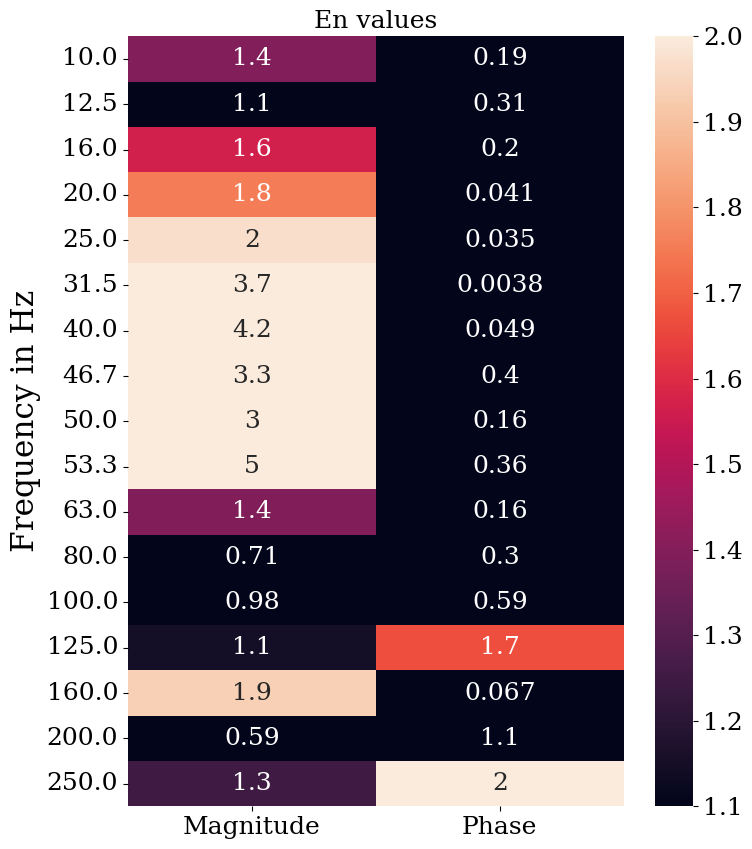

In [71]:
plt.figure(figsize=(8,10))
sns.heatmap(En_values_MC_, vmax=2, vmin=1.1,annot=True,yticklabels=PTB_separated_by_freq.keys(),xticklabels=["Magnitude","Phase"] )
plt.title("En values")
plt.ylabel("Frequency in Hz")
plt.show()

The results are similar to those obtained by the second approach and show good agreement for the phase values at frequencies lower than 125.0 Hz, while the En values of magnitudes are sensitive to the sample size and decreases at higher frequencies. <br>*Note: it is not sure whether the sampling is an applicable option for measurement procedure by the acceleration sensor. Also, as the sample size can be changed, iterations can be made to examine its effect and randomness on the quantities of interest.*

# Conclusion

All approaches incorporated through En values show disagreement in magnitude values,while the phase values satisfy the set criteria at frequencies up to 100.0 Hz (Case study6
2 and 3) and up to 80 Hz (Case study 1).   When considering the above mentioned approaches, some limitations exist for the Case study 1 (the assumption of the equal variance)and Case study 3 (sampling and sampling size).  However, all three approaches show thehighest En values for magnitude in a mid-range of frequencies, which is in line with the trends shown in Introduction data analysis, especially in the range (31.5 – 53.3) Hz.  All three approaches are also aligned with plots in Introduction data analysis in terms of phase.  High En values in upper frequencies correspond to the area of a small peak around 160.0 Hz in averaged CV.  It is worth noting that current calculation relies only on statistical uncertainty contribution. Therefore,it includes only type A information, without additional sources from the Type B uncertainty evaluation. This means that the possible implications and effects coming from other sources(mechanisms, environmental conditions, etc.)  were not taken into account.  Nevertheless,some current mechanical problems and behaviour of both set-ups are known and mightcause disagreement of results, especially for the magnitude. The effect of temperature also requires further analysis since a potential relation was identifies.  The position of the temperature sensor is also to be considered. If the temperature is not affected by the presenceof people, the change of magnitude and phase shows opposite behaviour in a relation to the change of temperature. Additionally, the Pearson correlation coefficients between temperature and magnitude; temperature and phase were calculated at each frequency for PTB and CEM. The correlation coefficients demonstrate moderately strong or very strong negative correlation (based on some guidelines).  Nevertheless, a 95% confidence interval has been calculated for the correlation coefficient at each frequency. The lower and upper limits of aconfidence interval for correlation coefficients have different sign at all frequencies except 40.0 Hz for PTB and at all frequencies except 160.0 Hz for CEM which means that it cannot be fully accepted that the correlation is negative. The correlation was further examined by significance testing (p-value can be calculated. The null hypothesis that states that there is no relationships between magnitude and temperature can be rejected at frequencies 40.0Hz and for PTB and at 160.0 Hz for CEM because the p-values are less than 0.05. The null hypothesis that states that there is no relationships between phase and temperature can berejected only at a frequencies of 20.0 Hz and 50.0 Hz for PTB because the p-value is less than0.05. Note that Pearson correlation also refers to the measure of the linear relationship. 

# References

[1] https://www.investopedia.com/terms/c/coefficientofvariation.asp
<br>[2] https://en.wikipedia.org/wiki/Weighted_arithmetic_mean
<br>[3] https://en.wikipedia.org/wiki/Effective_sample_size
<br>[4] https://online.stat.psu.edu/stat500/lesson/10/10.2/10.2.1
<br>[5] https://www.marsja.se/levenes-bartletts-test-of-equality-homogeneity-of-variance-in-python/